In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from modules import *
from networks import *
from training import *

In [2]:
TRAIN_IMAGES_DIR = ['../data/ORIGA-cropped/TrainImages']
TRAIN_MASKS_DIR = ['../data/ORIGA-cropped/TrainMasks']
VAL_IMAGES_DIR = ['../data/ORIGA-cropped/TestImages']
VAL_MASKS_DIR = ['../data/ORIGA-cropped/TestMasks']
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_WORKERS = 0
PIN_MEMORY = True if DEVICE == 'cuda' else False

IN_CHANNELS = 3
OUT_CHANNELS = 3
EPOCHS = 5
LR = 1e-4

## Segmentation Models PyTorch

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights='imagenet',
    in_channels=IN_CHANNELS,
    classes=OUT_CHANNELS,
    # decoder_attention_type='scse',
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
preprocess_input = get_preprocessing_fn(ENCODER, pretrained=ENCODER_WEIGHTS)

In [5]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    # A.Lambda(image=preprocess_input),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    # A.Lambda(image=preprocess_input),
    # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.255]),
    ToTensorV2(),
])

train_loader = load_dataset(
    TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, train_transform,
    BATCH_SIZE, NUM_WORKERS, PIN_MEMORY, shuffle=True,
)
val_loader = load_dataset(
    VAL_IMAGES_DIR, VAL_MASKS_DIR, val_transform,
    BATCH_SIZE, NUM_WORKERS, PIN_MEMORY, shuffle=False,
)

Loaded dataset with 325 samples in 82 batches.
Loaded dataset with 325 samples in 82 batches.


In [ ]:
# Freeze encoder weights
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
model = model.to(DEVICE)

hist = defaultdict(list)
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}:')

    model.train()
    metrics = defaultdict(list)
    for images, masks in tqdm(train_loader):
        images = images.float().to(DEVICE)
        masks = masks.long().to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, masks)

        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metrics['loss'].append(loss.item())
        update_metrics(masks, preds, metrics, [[1, 2], [2]])
    update_history(hist, {k: np.mean(v) for k, v in metrics.items()}, prefix='train')
    print(f'''Training:
    Loss: {hist['train_loss'][-1]:.4f}
    Accuracy: {hist['train_accuracy_OD'][-1]:.4f} (Disc), {hist['train_accuracy_OC'][-1]:.4f} (Cup)
    Dice: {hist['train_dice_OD'][-1]:.4f} (Disc), {hist['train_dice_OC'][-1]:.4f} (Cup)
    ''')

    model.eval()
    metrics = defaultdict(list)
    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images = images.float().to(DEVICE)
            masks = masks.long().to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, masks)

            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            metrics['loss'].append(loss.item())
            update_metrics(masks, preds, metrics, [[1, 2], [2]])
        update_history(hist, {k: np.mean(v) for k, v in metrics.items()}, prefix='val')
    print(f'''Validation:
    Loss: {hist['val_loss'][-1]:.4f}
    Accuracy: {hist['val_accuracy_OD'][-1]:.4f} (Disc), {hist['val_accuracy_OC'][-1]:.4f} (Cup)
    Dice: {hist['val_dice_OD'][-1]:.4f} (Disc), {hist['val_dice_OC'][-1]:.4f} (Cup)
    ''')


In [ ]:
plot_history(hist)

In [ ]:
# Plot some predictions
model.eval()
images, masks = next(iter(val_loader))
images = images.float().to(DEVICE)
masks = masks.long().to(DEVICE)

outputs = model(images)
probs = F.softmax(outputs, dim=1)
preds = torch.argmax(probs, dim=1)

images = images.detach().cpu().numpy().transpose(0, 2, 3, 1) / 255
masks = masks.detach().cpu().numpy()
preds = preds.detach().cpu().numpy()

_, ax = plt.subplots(3, 3, figsize=(8, 8))
for i in range(3):
    image = images[i]
    image -= image.min()
    image /= image.max()
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(masks[i])
    ax[i, 2].imshow(preds[i])
plt.tight_layout()
plt.show()

### Segformer

In [ ]:
from math import sqrt
from functools import partial
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, reduce
from einops.layers.torch import Rearrange


# helpers

def exists(val):
    return val is not None


def cast_tuple(val, depth):
    return val if isinstance(val, tuple) else (val,) * depth


# classes

class DsConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride=1, bias=True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size=kernel_size, padding=padding, groups=dim_in, stride=stride,
                      bias=bias),
            nn.Conv2d(dim_in, dim_out, kernel_size=1, bias=bias)
        )

    def forward(self, x):
        return self.net(x)


class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim=1, unbiased=False, keepdim=True).sqrt()
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.g + self.b


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))


class EfficientSelfAttention(nn.Module):
    def __init__(
            self,
            *,
            dim,
            heads,
            reduction_ratio
    ):
        super().__init__()
        self.scale = (dim // heads) ** -0.5
        self.heads = heads

        self.to_q = nn.Conv2d(dim, dim, 1, bias=False)
        self.to_kv = nn.Conv2d(dim, dim * 2, reduction_ratio, stride=reduction_ratio, bias=False)
        self.to_out = nn.Conv2d(dim, dim, 1, bias=False)

    def forward(self, x):
        h, w = x.shape[-2:]
        heads = self.heads

        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim=1))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h=heads), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale
        attn = sim.softmax(dim=-1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) (x y) c -> b (h c) x y', h=heads, x=h, y=w)
        return self.to_out(out)


class MixFeedForward(nn.Module):
    def __init__(
            self,
            *,
            dim,
            expansion_factor
    ):
        super().__init__()
        hidden_dim = dim * expansion_factor
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1),
            DsConv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1)
        )

    def forward(self, x):
        return self.net(x)


class MiT(nn.Module):
    def __init__(
            self,
            *,
            channels,
            dims,
            heads,
            ff_expansion,
            reduction_ratio,
            num_layers
    ):
        super().__init__()
        stage_kernel_stride_pad = ((7, 4, 3), (3, 2, 1), (3, 2, 1), (3, 2, 1))

        dims = (channels, *dims)
        dim_pairs = list(zip(dims[:-1], dims[1:]))

        self.stages = nn.ModuleList([])

        for (dim_in, dim_out), (kernel, stride, padding), num_layers, ff_expansion, heads, reduction_ratio in zip(
                dim_pairs, stage_kernel_stride_pad, num_layers, ff_expansion, heads, reduction_ratio):
            get_overlap_patches = nn.Unfold(kernel, stride=stride, padding=padding)
            overlap_patch_embed = nn.Conv2d(dim_in * kernel ** 2, dim_out, 1)

            layers = nn.ModuleList([])

            for _ in range(num_layers):
                layers.append(nn.ModuleList([
                    PreNorm(dim_out, EfficientSelfAttention(dim=dim_out, heads=heads, reduction_ratio=reduction_ratio)),
                    PreNorm(dim_out, MixFeedForward(dim=dim_out, expansion_factor=ff_expansion)),
                ]))

            self.stages.append(nn.ModuleList([
                get_overlap_patches,
                overlap_patch_embed,
                layers
            ]))

    def forward(
            self,
            x,
            return_layer_outputs=False
    ):
        h, w = x.shape[-2:]

        layer_outputs = []
        for (get_overlap_patches, overlap_embed, layers) in self.stages:
            x = get_overlap_patches(x)

            num_patches = x.shape[-1]
            ratio = int(sqrt((h * w) / num_patches))
            x = rearrange(x, 'b c (h w) -> b c h w', h=h // ratio)

            x = overlap_embed(x)
            for (attn, ff) in layers:
                x = attn(x) + x
                x = ff(x) + x

            layer_outputs.append(x)

        ret = x if not return_layer_outputs else layer_outputs
        return ret


class Segformer(nn.Module):
    def __init__(
            self,
            *,
            dims=(32, 64, 160, 256),
            heads=(1, 2, 5, 8),
            ff_expansion=(8, 8, 4, 4),
            reduction_ratio=(8, 4, 2, 1),
            num_layers=2,
            channels=3,
            decoder_dim=256,
            num_classes=4
    ):
        super().__init__()
        dims, heads, ff_expansion, reduction_ratio, num_layers = map(
            partial(cast_tuple, depth=4), (dims, heads, ff_expansion, reduction_ratio, num_layers))
        assert all([*map(lambda t: len(t) == 4, (dims, heads, ff_expansion, reduction_ratio, num_layers))]), \
            'only four stages are allowed, all keyword arguments must be either a single value or a tuple of 4 values'

        self.mit = MiT(
            channels=channels,
            dims=dims,
            heads=heads,
            ff_expansion=ff_expansion,
            reduction_ratio=reduction_ratio,
            num_layers=num_layers
        )

        self.to_fused = nn.ModuleList([nn.Sequential(
            nn.Conv2d(dim, decoder_dim, 1),
            nn.Upsample(scale_factor=2 ** i)
        ) for i, dim in enumerate(dims)])

        self.to_segmentation = nn.Sequential(
            nn.Conv2d(4 * decoder_dim, decoder_dim, 1),
            nn.Conv2d(decoder_dim, num_classes, 1),
        )

    def forward(self, x):
        layer_outputs = self.mit(x, return_layer_outputs=True)

        fused = [to_fused(output) for output, to_fused in zip(layer_outputs, self.to_fused)]
        fused = torch.cat(fused, dim=1)
        seg = self.to_segmentation(fused)

        # resize to original size
        seg = F.interpolate(seg, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return seg

In [ ]:
model = Segformer(
    dims=(32, 64, 160, 256),  # dimensions of each stage
    heads=(1, 2, 5, 8),  # heads of each stage
    ff_expansion=(8, 8, 4, 4),  # feedforward expansion factor of each stage
    reduction_ratio=(8, 4, 2, 1),  # reduction ratio of each stage for efficient attention
    num_layers=2,  # num layers of each stage
    decoder_dim=256,  # decoder dimension
    num_classes=3  # number of segmentation classes
)

IMAGE_SIZE = 256

x = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
pred = model(x)
print(pred.shape)  # (1, num_classes, IMAGE_SIZE, IMAGE_SIZE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# gt = torch.randint(0, 3, (1, IMAGE_SIZE, IMAGE_SIZE))
# loss = criterion(pred, gt)

## HuggingFace Transformers

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 as cv
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor, SegformerConfig, TrainingArguments, \
    Trainer
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, feature_extractor, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.feature_extractor = feature_extractor
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB)

        mask = None
        if self.mask_paths is not None:
            mask_path = self.mask_paths[idx]
            mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        if not isinstance(mask, torch.Tensor):
            mask = torch.tensor(mask, dtype=torch.long)
        else:
            mask = mask.long()

        image = self.feature_extractor(images=image.unsqueeze(0))['pixel_values'][0]
        image = torch.from_numpy(image)
        return {"pixel_values": image, "labels": mask}


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
id2label = {
    0: 'background',
    1: 'optic disc',
    2: 'optic cup',
}
label2id = {v: k for k, v in id2label.items()}

train_image_paths = [f'../data/ORIGA-cropped/TrainImages/{f}' for f in os.listdir('../data/ORIGA-cropped/TrainImages')]
train_mask_paths = [f'../data/ORIGA-cropped/TrainMasks/{f}' for f in os.listdir('../data/ORIGA-cropped/TrainMasks')]
val_image_paths = [f'../data/ORIGA-cropped/TestImages/{f}' for f in os.listdir('../data/ORIGA-cropped/TestImages')]
val_mask_paths = [f'../data/ORIGA-cropped/TestMasks/{f}' for f in os.listdir('../data/ORIGA-cropped/TestMasks')]

IMAGE_SIZE = 512
transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    ToTensorV2(),
])

len(train_image_paths), len(train_mask_paths), len(val_image_paths), len(val_mask_paths)

(325, 325, 325, 325)

In [2]:
pretrained_model = 'nvidia/segformer-b0-finetuned-ade-512-512'

feature_extractor = SegformerImageProcessor.from_pretrained(pretrained_model)

config = SegformerConfig.from_pretrained(pretrained_model)
config.num_labels = 3
config.label2id = label2id
config.id2label = id2label

# model = SegformerForSemanticSegmentation.from_pretrained(pretrained_model)
model = SegformerForSemanticSegmentation(config)

sample = torch.randn(2, 3, IMAGE_SIZE, IMAGE_SIZE)
outputs = model(sample)
print(outputs.logits.shape)

C:\Users\ASUS\PycharmProjects\DP-GlaucomaSegmentation\venv\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


torch.Size([2, 3, 128, 128])


In [3]:
train_dataset = CustomDataset(train_image_paths, train_mask_paths, feature_extractor, transform)
val_dataset = CustomDataset(val_image_paths, val_mask_paths, feature_extractor, transform)

sample = train_dataset[0]
pixel_values = sample['pixel_values']
labels = sample['labels']

print(pixel_values.shape, labels.shape)

torch.Size([3, 512, 512]) torch.Size([512, 512])


In [5]:
training_args = TrainingArguments(
    output_dir="./segformer-b0",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    learning_rate=6e-5,
    weight_decay=0.01,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    report_to=[],  # disable logging
    logging_dir="./logs",
    logging_steps=10,
    eval_steps=1000,
    save_steps=1000,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Step,Training Loss,Validation Loss
1000,0.149900,0.177737
2000,0.093200,0.135260
3000,0.113500,0.106015
4000,0.085900,0.121798
5000,0.126200,0.102866
6000,0.072600,0.101974
7000,0.070000,0.098635
8000,0.067700,0.097993


TrainOutput(global_step=8150, training_loss=0.10646169475982525, metrics={'train_runtime': 2601.6907, 'train_samples_per_second': 6.246, 'train_steps_per_second': 3.133, 'total_flos': 2.848489832448e+17, 'train_loss': 0.10646169475982525, 'epoch': 50.0})

In [11]:
model = SegformerForSemanticSegmentation.from_pretrained("./segformer-b0/checkpoint-8000")

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [21]:
from collections import defaultdict
from tqdm import tqdm
from modules import update_metrics

model = model.to(DEVICE)
model.eval()

metrics = defaultdict(list)
with torch.no_grad():
    for data in tqdm(val_dataset):
        images = data['pixel_values'].unsqueeze(0).to(DEVICE)
        masks = data['labels'].unsqueeze(0).to(DEVICE)

        output = model(images)
        logits = output.logits
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=images.shape[-2:],
            mode='bilinear',
            align_corners=False
        )
        preds = upsampled_logits.argmax(dim=1)
        update_metrics(masks, preds, metrics, [[1, 2], [2]])

for k, v in metrics.items():
    print(f'{k}: {np.mean(v):.4f}')

100%|██████████| 325/325 [00:19<00:00, 16.46it/s]

accuracy_OD: 0.9815
precision_OD: 0.9544
sensitivity_OD: 0.9467
specificity_OD: 0.9897
dice_OD: 0.9479
iou_OD: 0.9038
balance_accuracy_OD: 0.9682
tp_OD: 44996.4462
tn_OD: 212284.8000
fp_OD: 2220.9569
fn_OD: 2641.7969
accuracy_OC: 0.9787
precision_OC: 0.8960
sensitivity_OC: 0.8221
specificity_OC: 0.9924
dice_OC: 0.8361
iou_OC: 0.7299
balance_accuracy_OC: 0.9072
tp_OC: 14542.1292
tn_OC: 242016.8369
fp_OC: 1881.7015
fn_OC: 3703.3323


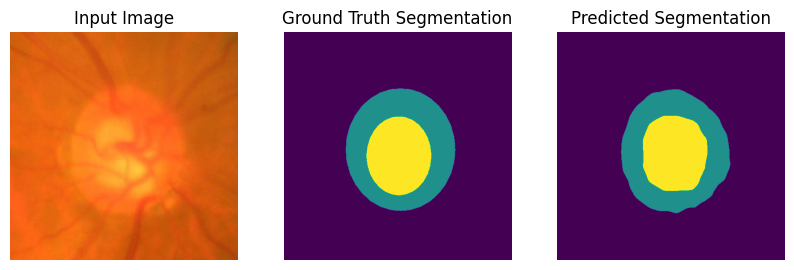

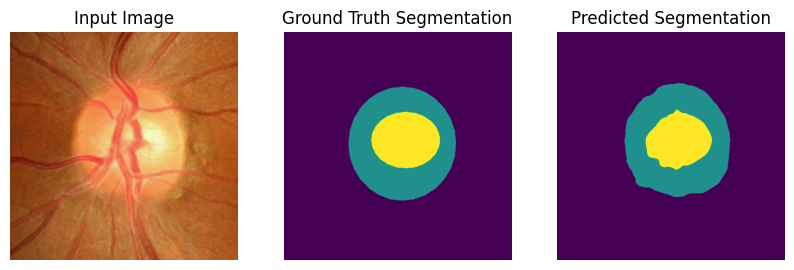

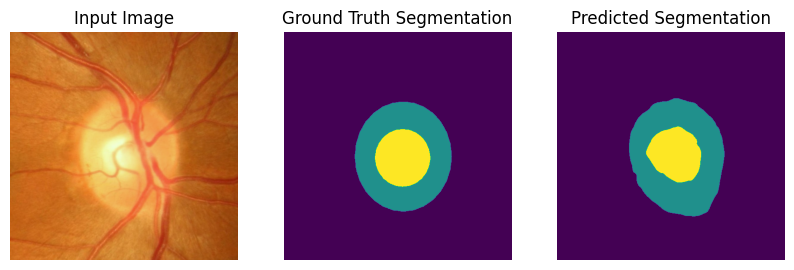

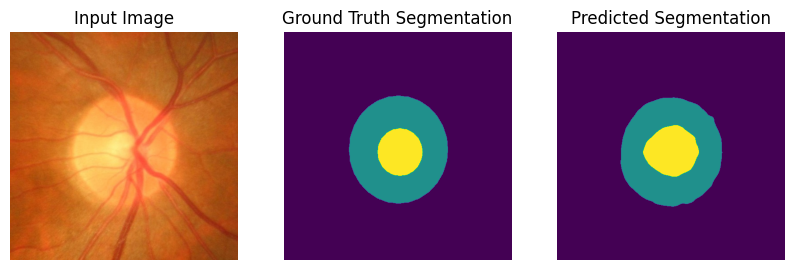

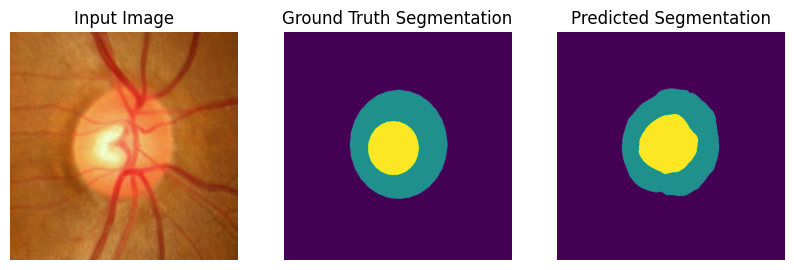

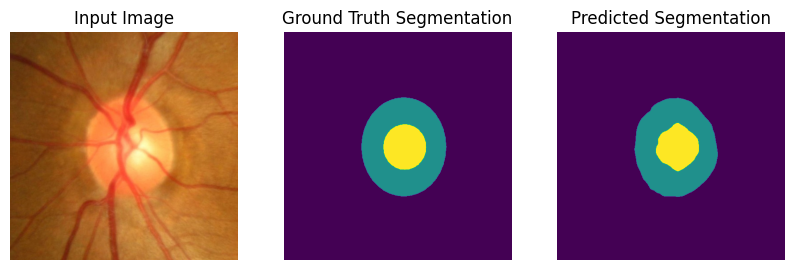

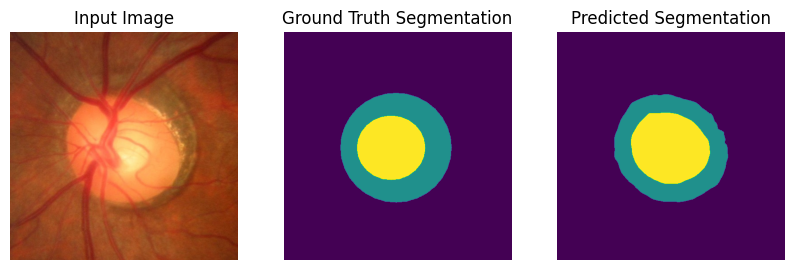

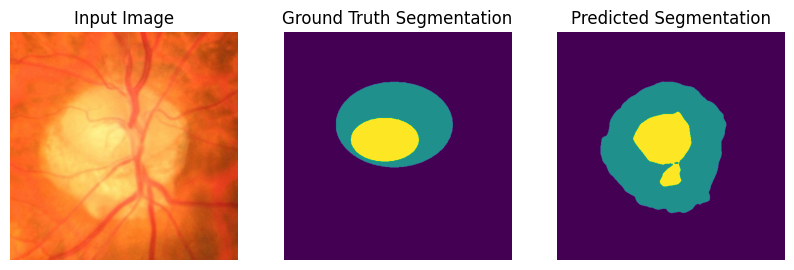

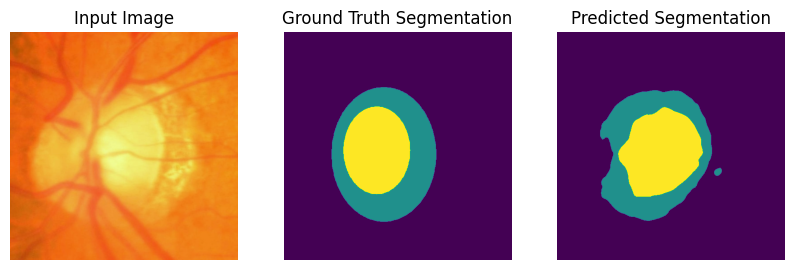

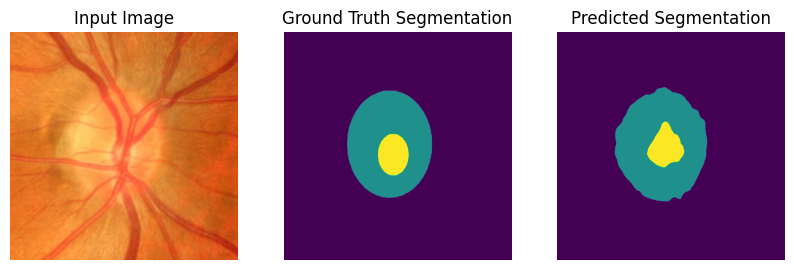

In [14]:
model = model.to(DEVICE)
model.eval()
for i in range(10):
    sample = val_dataset[i]
    image = sample['pixel_values']
    gt_seg = sample['labels']

    image = image.to(DEVICE).unsqueeze(0)
    with torch.no_grad():
        outputs = model(image)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.shape[-2:],
        mode='bilinear',
        align_corners=False
    )

    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]
    pred_seg = pred_seg.detach().cpu().numpy()

    print(image.shape)
    print(gt_seg.shape)
    print(pred_seg.shape)

    img = image[0].permute(1, 2, 0).cpu()
    img -= img.min()
    img /= img.max()

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(gt_seg)
    plt.title("Ground Truth Segmentation")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_seg)
    plt.title("Predicted Segmentation")
    plt.axis('off')
    plt.show()